# CICIDS-2017 Data Preparation for Threat Assessment Framework
# Research Implementation - Phase 1
# Dataset: CICIDS-2017 (2.8M+ network flows, 5 days, 80+ features)


In [4]:
# ============================================
# SECTION 1: Environment Setup
# ============================================

# Install required libraries
!pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn
!pip install sdv ctgan  # For synthetic data generation

# Mount Google Drive (optional - for saving processed data)
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.3/193.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 136.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.2 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/mythesis/akhila/CICIDS2017

/content/drive/MyDrive/mythesis/akhila/CICIDS2017


In [ ]:
# ============================================
# SECTION 2: Download Dataset from Kaggle
# ============================================

# Method 1: Direct Kaggle API Download
!pip install kaggle

# Upload your kaggle.json file (from Kaggle Account Settings)
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download CICIDS2017 dataset
!kaggle datasets download -d chethuhn/network-intrusion-dataset -p /content/drive/MyDrive/mythesis/akhila/CICIDS2017
!unzip network-intrusion-dataset.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset
License(s): CC0-1.0
network-intrusion-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  network-intrusion-dataset.zip
  inflating: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  
  inflating: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  inflating: Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: Monday-WorkingHours.pcap_ISCX.csv  
  inflating: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: Wednesday-workingHours.pcap_ISCX.csv  


In [6]:
# ============================================
# SECTION 3: Load and Explore Dataset
# ============================================

# List all CSV files in the dataset
import os
csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]
print(f"Found {len(csv_files)} CSV files:")
for i, file in enumerate(csv_files, 1):
    print(f"{i}. {file}")

# Load first CSV file as example (adjust filename as needed)
# The dataset is split across multiple days
df_monday = pd.read_csv('Monday-WorkingHours.pcap_ISCX.csv')  # Adjust filename

print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Shape: {df_monday.shape}")
print(f"\nColumns ({len(df_monday.columns)}):")
print(df_monday.columns.tolist())
print(f"\nFirst 5 rows:")
print(df_monday.head())

# Check data types
print("\n" + "="*60)
print("DATA TYPES")
print("="*60)
print(df_monday.dtypes.value_counts())

# Check for missing values
print("\n" + "="*60)
print("MISSING VALUES")
print("="*60)
missing = df_monday.isnull().sum()
missing_pct = (missing / len(df_monday)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing': missing.values,
    'Percentage': missing_pct.values
})
print(missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False))

Found 8 CSV files:
1. Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
2. Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
3. Friday-WorkingHours-Morning.pcap_ISCX.csv
4. Monday-WorkingHours.pcap_ISCX.csv
5. Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
6. Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
7. Tuesday-WorkingHours.pcap_ISCX.csv
8. Wednesday-workingHours.pcap_ISCX.csv

DATASET OVERVIEW
Shape: (529918, 79)

Columns (79):
[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IA

In [7]:
# ============================================
# SECTION 4: Combine All Daily Files
# ============================================

def load_all_csv_files(file_pattern='*.csv'):
    """Load and combine all CICIDS2017 CSV files"""
    dfs = []
    for file in csv_files:
        print(f"Loading {file}...")
        df = pd.read_csv(file, low_memory=False)
        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"\nCombined dataset shape: {combined_df.shape}")
    return combined_df

# Load all files
df_full = load_all_csv_files()

Loading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
Loading Friday-WorkingHours-Morning.pcap_ISCX.csv...
Loading Monday-WorkingHours.pcap_ISCX.csv...
Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
Loading Tuesday-WorkingHours.pcap_ISCX.csv...
Loading Wednesday-workingHours.pcap_ISCX.csv...

Combined dataset shape: (2830743, 79)



CLASS DISTRIBUTION (Attack Types)
 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

Total samples: 2,830,743
Number of classes: 15
Imbalance ratio (majority/minority): 206645.18


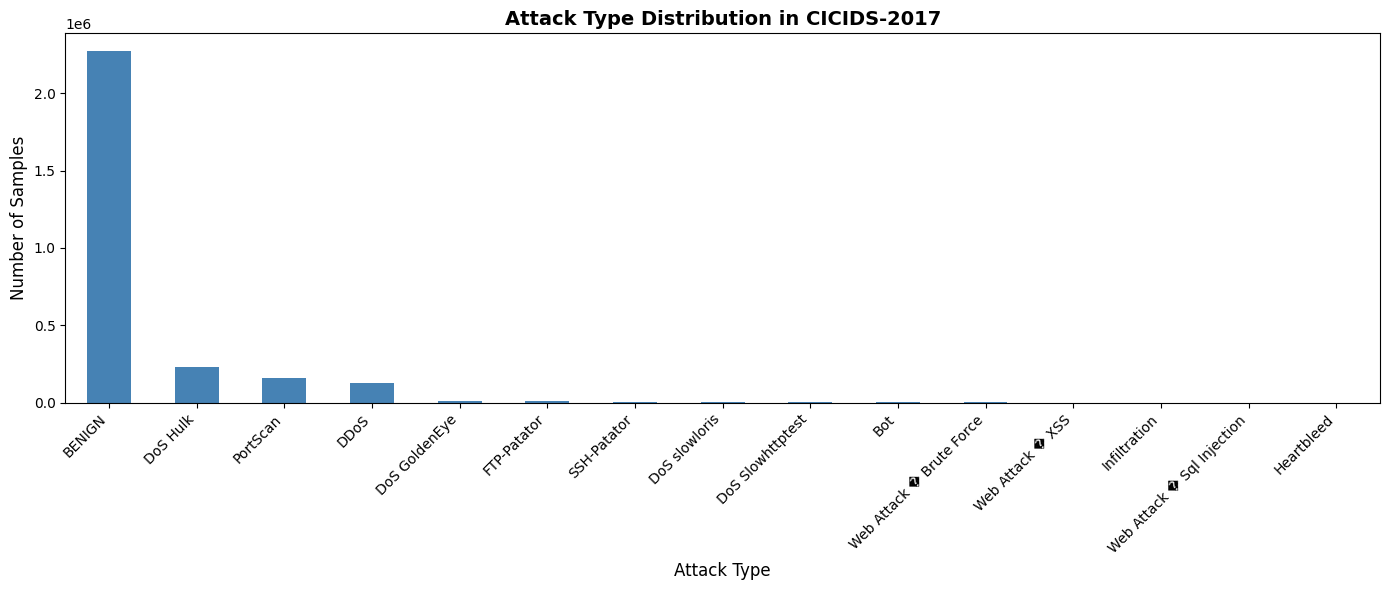

In [8]:
# ============================================
# SECTION 5: Class Distribution Analysis
# ============================================

print("\n" + "="*60)
print("CLASS DISTRIBUTION (Attack Types)")
print("="*60)

# Assuming 'Label' column contains attack types
label_col = 'Label' if 'Label' in df_full.columns else ' Label'  # Handle space

class_dist = df_full[label_col].value_counts()
print(class_dist)

# Calculate class imbalance ratio
print(f"\nTotal samples: {len(df_full):,}")
print(f"Number of classes: {df_full[label_col].nunique()}")
print(f"Imbalance ratio (majority/minority): {class_dist.max() / class_dist.min():.2f}")

# Visualize class distribution
plt.figure(figsize=(14, 6))
class_dist.plot(kind='bar', color='steelblue')
plt.title('Attack Type Distribution in CICIDS-2017', fontsize=14, fontweight='bold')
plt.xlabel('Attack Type', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
# ============================================
# SECTION 6: Data Preprocessing
# ============================================

def preprocess_cicids_data(df, label_column='Label'):
    """
    Comprehensive preprocessing for CICIDS-2017 dataset

    Steps:
    1. Handle missing values
    2. Remove duplicates
    3. Handle infinite values
    4. Encode labels
    5. Feature normalization
    """

    print("\n" + "="*60)
    print("PREPROCESSING PIPELINE")
    print("="*60)

    df_clean = df.copy()

    # Step 1: Strip whitespace from column names
    df_clean.columns = df_clean.columns.str.strip()

    # Step 2: Handle missing values
    print(f"\n1. Handling missing values...")
    print(f"   Before: {df_clean.isnull().sum().sum()} missing values")

    # Replace inf with NaN
    df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with missing labels
    df_clean.dropna(subset=[label_column], inplace=True)

    # Fill numeric columns with median
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

    print(f"   After: {df_clean.isnull().sum().sum()} missing values")

    # Step 3: Remove duplicates
    print(f"\n2. Removing duplicates...")
    print(f"   Before: {len(df_clean):,} rows")
    df_clean.drop_duplicates(inplace=True)
    print(f"   After: {len(df_clean):,} rows")

    # Step 4: Encode labels
    print(f"\n3. Encoding labels...")
    le = LabelEncoder()
    df_clean['Label_Encoded'] = le.fit_transform(df_clean[label_column])

    # Save label mapping
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"   Label mapping:")
    for label, code in label_mapping.items():
        print(f"   {code}: {label}")

    # Step 5: Separate features and target
    X = df_clean.drop([label_column, 'Label_Encoded'], axis=1, errors='ignore')
    y = df_clean['Label_Encoded']

    # Remove non-numeric features (if any)
    X = X.select_dtypes(include=[np.number])

    print(f"\n4. Final dataset shape:")
    print(f"   Features (X): {X.shape}")
    print(f"   Target (y): {y.shape}")

    return X, y, le

# Apply preprocessing
X, y, label_encoder = preprocess_cicids_data(df_full)



PREPROCESSING PIPELINE

1. Handling missing values...
   Before: 1358 missing values
   After: 0 missing values

2. Removing duplicates...
   Before: 2,830,743 rows
   After: 2,522,362 rows

3. Encoding labels...
   Label mapping:
   0: BENIGN
   1: Bot
   2: DDoS
   3: DoS GoldenEye
   4: DoS Hulk
   5: DoS Slowhttptest
   6: DoS slowloris
   7: FTP-Patator
   8: Heartbleed
   9: Infiltration
   10: PortScan
   11: SSH-Patator
   12: Web Attack � Brute Force
   13: Web Attack � Sql Injection
   14: Web Attack � XSS

4. Final dataset shape:
   Features (X): (2522362, 78)
   Target (y): (2522362,)


In [10]:
# ============================================
# SECTION 7: Feature Normalization
# ============================================

print("\n" + "="*60)
print("FEATURE NORMALIZATION")
print("="*60)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"Scaled features shape: {X_scaled.shape}")
print(f"\nSample statistics after scaling:")
print(X_scaled.describe())



FEATURE NORMALIZATION
Scaled features shape: (2522362, 78)

Sample statistics after scaling:
       Destination Port  Flow Duration  Total Fwd Packets  \
count      2.522362e+06   2.522362e+06       2.522362e+06   
mean      -2.496965e-17   7.283567e-17       3.943763e-20   
std        1.000000e+00   1.000000e+00       1.000000e+00   
min       -4.575418e-01  -4.707364e-01      -1.168041e-02   
25%       -4.547560e-01  -4.707301e-01      -1.042124e-02   
50%       -4.533369e-01  -4.693001e-01      -1.042124e-02   
75%       -4.342568e-01  -3.194278e-01      -5.384555e-03   
max        2.987125e+00   2.936008e+00       2.767011e+02   

       Total Backward Packets  Total Length of Fwd Packets  \
count            2.522362e+06                 2.522362e+06   
mean            -2.873313e-19                -7.842455e-18   
std              1.000000e+00                 1.000000e+00   
min             -1.094646e-02                -5.777757e-02   
25%             -1.000002e-02                -

In [11]:
# ============================================
# SECTION 8: Train-Validation-Test Split (70-15-15)
# ============================================

print("\n" + "="*60)
print("TRAIN-VALIDATION-TEST SPLIT")
print("="*60)

# First split: 70% train, 30% temp (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test (from 30% temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X):.1%})")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X):.1%})")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X):.1%})")

# Check class distribution in splits
print("\nClass distribution in splits:")
for split_name, split_data in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    print(f"\n{split_name}:")
    print(split_data.value_counts().head())


TRAIN-VALIDATION-TEST SPLIT
Training set: 1,765,653 samples (70.0%)
Validation set: 378,354 samples (15.0%)
Test set: 378,355 samples (15.0%)

Class distribution in splits:

Train:
Label_Encoded
0     1467539
4      120994
2       89611
10      63573
3        7200
Name: count, dtype: int64

Val:
Label_Encoded
0     314472
4      25927
2      19202
10     13623
3       1543
Name: count, dtype: int64

Test:
Label_Encoded
0     314473
4      25928
2      19203
10     13623
3       1543
Name: count, dtype: int64


In [12]:
%cd /content/drive/MyDrive/mythesis/akhila/CICIDS2017/processed

/content/drive/MyDrive/mythesis/akhila/CICIDS2017/processed


In [13]:
# ============================================
# SECTION 9: Save Processed Data
# ============================================

print("\n" + "="*60)
print("SAVING PROCESSED DATA")
print("="*60)

# Save to CSV
X_train.to_csv('X_train_cicids2017.csv', index=False)
X_val.to_csv('X_val_cicids2017.csv', index=False)
X_test.to_csv('X_test_cicids2017.csv', index=False)

pd.DataFrame(y_train).to_csv('y_train_cicids2017.csv', index=False)
pd.DataFrame(y_val).to_csv('y_val_cicids2017.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test_cicids2017.csv', index=False)

# Save scaler and label encoder
import joblib
joblib.dump(scaler, 'scaler_cicids2017.pkl')
joblib.dump(label_encoder, 'label_encoder_cicids2017.pkl')

print("✓ Data saved successfully!")
print("\nFiles created:")
print("  - X_train_cicids2017.csv")
print("  - X_val_cicids2017.csv")
print("  - X_test_cicids2017.csv")
print("  - y_train_cicids2017.csv")
print("  - y_val_cicids2017.csv")
print("  - y_test_cicids2017.csv")
print("  - scaler_cicids2017.pkl")
print("  - label_encoder_cicids2017.pkl")

# Optional: Save to Google Drive
# Uncomment to use
# !cp *.csv /content/drive/MyDrive/CICIDS2017_Processed/
# !cp *.pkl /content/drive/MyDrive/CICIDS2017_Processed/

print("\n" + "="*60)
print("DATA PREPARATION COMPLETE!")
print("="*60)
print("\nNext Steps:")
print("1. Implement CTGAN for synthetic data generation")
print("2. Build Transformer architecture for temporal analysis")
print("3. Build GNN architecture for structural analysis")
print("4. Develop meta-learner ensemble")


SAVING PROCESSED DATA
✓ Data saved successfully!

Files created:
  - X_train_cicids2017.csv
  - X_val_cicids2017.csv
  - X_test_cicids2017.csv
  - y_train_cicids2017.csv
  - y_val_cicids2017.csv
  - y_test_cicids2017.csv
  - scaler_cicids2017.pkl
  - label_encoder_cicids2017.pkl

DATA PREPARATION COMPLETE!

Next Steps:
1. Implement CTGAN for synthetic data generation
2. Build Transformer architecture for temporal analysis
3. Build GNN architecture for structural analysis
4. Develop meta-learner ensemble


In [ ]:
# CTGAN Synthetic Data Generation for CICIDS-2017
# Addresses class imbalance through conditional generation
# Target: Generate 500K synthetic samples for minority attack classes

# ============================================
# SECTION 1: Install and Import Libraries
# ============================================

!pip install sdv ctgan pandas numpy scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ctgan import CTGAN
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.3/193.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 126.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
%cd /content/drive/MyDrive/mythesis/akhila/CICIDS2017/processed

/content/drive/MyDrive/mythesis/akhila/CICIDS2017/processed


In [ ]:
# ============================================
# SECTION 2: Load Preprocessed Data
# ============================================

print("="*60)
print("LOADING PREPROCESSED CICIDS-2017 DATA")
print("="*60)

# Load the training data (from previous preprocessing)
X_train = pd.read_csv('X_train_cicids2017.csv')
y_train = pd.read_csv('y_train_cicids2017.csv')

# Combine features and labels for CTGAN
train_data = X_train.copy()
train_data['Label_Encoded'] = y_train.values

print(f"\nTraining data shape: {train_data.shape}")
print(f"Features: {X_train.shape[1]}")
print(f"Total samples: {len(train_data):,}")

LOADING PREPROCESSED CICIDS-2017 DATA

Training data shape: (1765653, 79)
Features: 78
Total samples: 1,765,653



CLASS IMBALANCE ANALYSIS

Class distribution:
Label_Encoded
0     1467539
1        1367
2       89611
3        7200
4      120994
5        3660
6        3770
7        4153
8           8
9          25
10      63573
11       2253
12       1029
13         15
14        456
Name: count, dtype: int64

Majority class: 0 (1,467,539 samples)
Minority class: 8 (8 samples)
Imbalance ratio: 183442.38:1


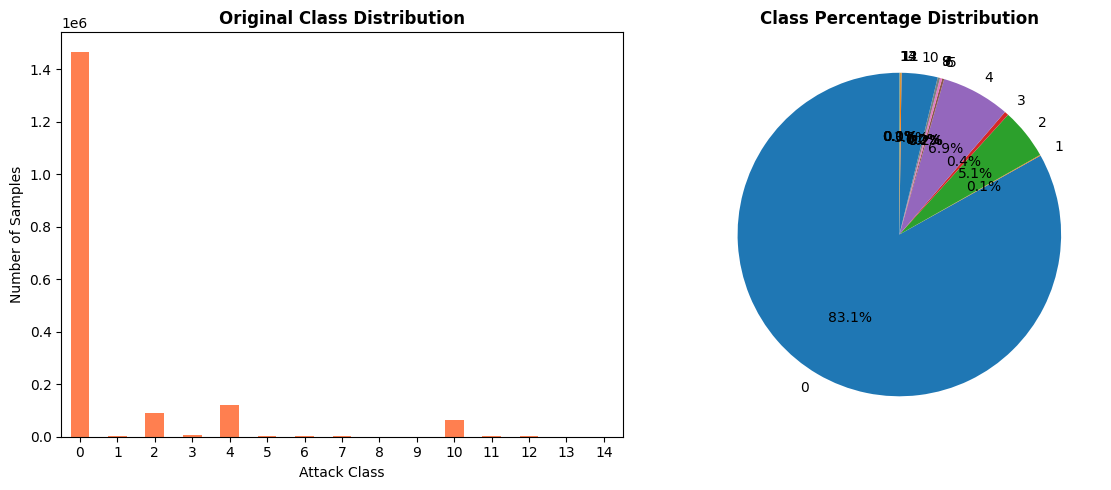

In [ ]:
# ============================================
# SECTION 3: Analyze Class Imbalance
# ============================================

print("\n" + "="*60)
print("CLASS IMBALANCE ANALYSIS")
print("="*60)

class_counts = train_data['Label_Encoded'].value_counts().sort_index()
print("\nClass distribution:")
print(class_counts)

# Calculate imbalance metrics
majority_class_count = class_counts.max()
minority_class_count = class_counts.min()
imbalance_ratio = majority_class_count / minority_class_count

print(f"\nMajority class: {class_counts.idxmax()} ({majority_class_count:,} samples)")
print(f"Minority class: {class_counts.idxmin()} ({minority_class_count:,} samples)")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

# Visualize class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color='coral')
plt.title('Original Class Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Attack Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Percentage Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# SECTION 4: Identify Minority Classes
# ============================================

print("\n" + "="*60)
print("IDENTIFYING MINORITY CLASSES FOR AUGMENTATION")
print("="*60)

# Define threshold: classes with < 10% of majority class samples
threshold = majority_class_count * 0.10
minority_classes = class_counts[class_counts < threshold].index.tolist()

print(f"\nMinority classes (< 10% of majority): {len(minority_classes)} classes")
print(f"Classes to augment: {minority_classes}")

for cls in minority_classes:
    count = class_counts[cls]
    print(f"  Class {cls}: {count:,} samples ({count/majority_class_count*100:.2f}% of majority)")


IDENTIFYING MINORITY CLASSES FOR AUGMENTATION

Minority classes (< 10% of majority): 14 classes
Classes to augment: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  Class 1: 1,367 samples (0.09% of majority)
  Class 2: 89,611 samples (6.11% of majority)
  Class 3: 7,200 samples (0.49% of majority)
  Class 4: 120,994 samples (8.24% of majority)
  Class 5: 3,660 samples (0.25% of majority)
  Class 6: 3,770 samples (0.26% of majority)
  Class 7: 4,153 samples (0.28% of majority)
  Class 8: 8 samples (0.00% of majority)
  Class 9: 25 samples (0.00% of majority)
  Class 10: 63,573 samples (4.33% of majority)
  Class 11: 2,253 samples (0.15% of majority)
  Class 12: 1,029 samples (0.07% of majority)
  Class 13: 15 samples (0.00% of majority)
  Class 14: 456 samples (0.03% of majority)


In [ ]:
# ============================================
# SECTION 5: Configure CTGAN
# ============================================


print("\n" + "="*60)
print("CTGAN CONFIGURATION")
print("="*60)

# CTGAN hyperparameters - OPTIMIZED FOR SPEED
ctgan_params = {
    'epochs': 100,                    # Reduced from 300 (still effective)
    'batch_size': 1000,               # Increased for GPU efficiency (was 500)
    'generator_dim': (256, 256),      # Generator hidden layers
    'discriminator_dim': (256, 256),  # Discriminator hidden layers
    'generator_lr': 2e-4,             # Generator learning rate
    'discriminator_lr': 2e-4,         # Discriminator learning rate
    'discriminator_steps': 1,         # Discriminator training steps per generator step
    'verbose': True                   # Show training progress
}

print("\nCTGAN Hyperparameters (OPTIMIZED FOR GPU):")
for param, value in ctgan_params.items():
    print(f"  {param}: {value}")

# Check GPU availability
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n Using device: {device}")
if device == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Initialize CTGAN model
print("\nInitializing CTGAN model...")
ctgan = CTGAN(cuda=True if device == 'cuda' else False, **ctgan_params)


CTGAN CONFIGURATION

CTGAN Hyperparameters (OPTIMIZED FOR GPU):
  epochs: 100
  batch_size: 1000
  generator_dim: (256, 256)
  discriminator_dim: (256, 256)
  generator_lr: 0.0002
  discriminator_lr: 0.0002
  discriminator_steps: 1
  verbose: True

 Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB

Initializing CTGAN model...


In [ ]:
# ============================================
# SECTION 6: Train CTGAN on Full Dataset
# ============================================

print("\n" + "="*60)
print("TRAINING CTGAN MODEL")
print("="*60)

# OPTIMIZATION: Sample subset for faster training (remove for full training)
# Use this for testing/development, then scale to full dataset
SAMPLE_SIZE = 200000  # Use 200K samples for faster training
print(f"\n FAST MODE: Sampling {SAMPLE_SIZE:,} samples for training...")

# Stratified sampling to maintain class distribution
from sklearn.model_selection import train_test_split
train_sample, _ = train_test_split(
    train_data,
    train_size=SAMPLE_SIZE,
    stratify=train_data['Label_Encoded'],
    random_state=42
)

print(f"Training on {len(train_sample):,} samples...")


# Specify discrete columns (categorical)
discrete_columns = ['Label_Encoded']

# Train CTGAN
ctgan.fit(train_sample, discrete_columns=discrete_columns)


TRAINING CTGAN MODEL

 FAST MODE: Sampling 200,000 samples for training...
Training on 200,000 samples...


Gen. (-1.39) | Discrim. (-0.57): 100%|██████████| 100/100 [32:18<00:00, 19.38s/it]


In [ ]:
# ============================================
# SECTION 7: Generate Synthetic Data
# ============================================

print("\n" + "="*60)
print("GENERATING SYNTHETIC DATA")
print("="*60)

# Calculate samples needed for each minority class
# Target: Balance to 50% of majority class count
target_samples_per_class = int(majority_class_count * 0.50)

synthetic_samples = []

for cls in minority_classes:
    current_count = class_counts[cls]
    samples_needed = max(0, target_samples_per_class - current_count)

    print(f"\nClass {cls}:")
    print(f"  Current: {current_count:,} samples")
    print(f"  Target: {target_samples_per_class:,} samples")
    print(f"  Generating: {samples_needed:,} synthetic samples")

    # Generate synthetic samples conditioned on this class
    if samples_needed > 0:
        # Correct way to generate samples conditioned on a class
        synthetic_data = ctgan.sample(samples_needed, condition_column='Label_Encoded', condition_value=cls)
        synthetic_samples.append(synthetic_data)

# Combine all synthetic data
if synthetic_samples:
    synthetic_df = pd.concat(synthetic_samples, ignore_index=True)
    print(f"\n✓ Generated {len(synthetic_df):,} total synthetic samples")
else:
    synthetic_df = pd.DataFrame()


GENERATING SYNTHETIC DATA

Class 1:
  Current: 1,367 samples
  Target: 733,769 samples
  Generating: 732,402 synthetic samples

Class 2:
  Current: 89,611 samples
  Target: 733,769 samples
  Generating: 644,158 synthetic samples

Class 3:
  Current: 7,200 samples
  Target: 733,769 samples
  Generating: 726,569 synthetic samples

Class 4:
  Current: 120,994 samples
  Target: 733,769 samples
  Generating: 612,775 synthetic samples

Class 5:
  Current: 3,660 samples
  Target: 733,769 samples
  Generating: 730,109 synthetic samples

Class 6:
  Current: 3,770 samples
  Target: 733,769 samples
  Generating: 729,999 synthetic samples

Class 7:
  Current: 4,153 samples
  Target: 733,769 samples
  Generating: 729,616 synthetic samples

Class 8:
  Current: 8 samples
  Target: 733,769 samples
  Generating: 733,761 synthetic samples

Class 9:
  Current: 25 samples
  Target: 733,769 samples
  Generating: 733,744 synthetic samples

Class 10:
  Current: 63,573 samples
  Target: 733,769 samples
  Gen


SYNTHETIC DATA QUALITY VALIDATION

Statistical Comparison (Real vs Synthetic):

Real Data Statistics:
       Destination Port  Flow Duration  Total Fwd Packets  \
count      1.765653e+06   1.765653e+06       1.765653e+06   
mean      -4.593673e-04   9.300413e-05       9.980132e-05   
std        9.994090e-01   1.000026e+00       1.000648e+00   
min       -4.575418e-01  -4.707363e-01      -1.168041e-02   
25%       -4.547560e-01  -4.707301e-01      -1.042124e-02   
50%       -4.533369e-01  -4.692999e-01      -1.042124e-02   
75%       -4.342568e-01  -3.193874e-01      -5.384555e-03   
max        2.987125e+00   2.936008e+00       2.753148e+02   

       Total Backward Packets  Total Length of Fwd Packets  
count            1.765653e+06                 1.765653e+06  
mean             9.598004e-05                 2.643649e-04  
std              1.000613e+00                 1.118435e+00  
min             -1.094646e-02                -5.777757e-02  
25%             -1.000002e-02             

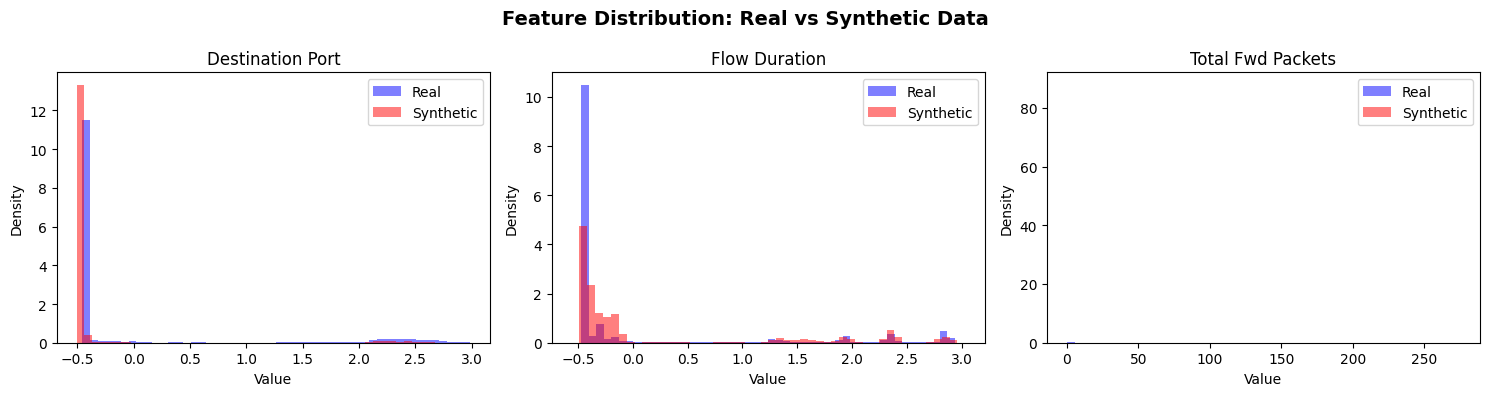


Synthetic data class distribution:
Label_Encoded
0     1287158
1      539850
2     1208426
3      631787
4     1359924
5      698339
6      773545
7      749533
8      117449
9      182217
10     760480
11     593923
12     566846
13     149453
14     355722
Name: count, dtype: int64


In [ ]:
# ============================================
# SECTION 8: Validate Synthetic Data Quality
# ============================================

print("\n" + "="*60)
print("SYNTHETIC DATA QUALITY VALIDATION")
print("="*60)

if not synthetic_df.empty:
    # Statistical comparison
    print("\nStatistical Comparison (Real vs Synthetic):")
    print("\nReal Data Statistics:")
    print(train_data.describe().iloc[:, :5])  # Show first 5 features

    print("\nSynthetic Data Statistics:")
    print(synthetic_df.describe().iloc[:, :5])

    # Feature distribution comparison (sample 3 features)
    sample_features = X_train.columns[:3]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for idx, feature in enumerate(sample_features):
        axes[idx].hist(train_data[feature], bins=50, alpha=0.5,
                      label='Real', color='blue', density=True)
        axes[idx].hist(synthetic_df[feature], bins=50, alpha=0.5,
                      label='Synthetic', color='red', density=True)
        axes[idx].set_title(f'{feature}')
        axes[idx].legend()
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Density')

    plt.suptitle('Feature Distribution: Real vs Synthetic Data',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Class distribution in synthetic data
    print("\nSynthetic data class distribution:")
    print(synthetic_df['Label_Encoded'].value_counts().sort_index())


COMBINING REAL AND SYNTHETIC DATA

Original training data: 1,765,653 samples
Synthetic data: 9,974,652 samples
Augmented data: 11,740,305 samples
Increase: 564.9%

AUGMENTED CLASS DISTRIBUTION
Label_Encoded
0     2754697
1      541217
2     1298037
3      638987
4     1480918
5      701999
6      777315
7      753686
8      117457
9      182242
10     824053
11     596176
12     567875
13     149468
14     356178
Name: count, dtype: int64


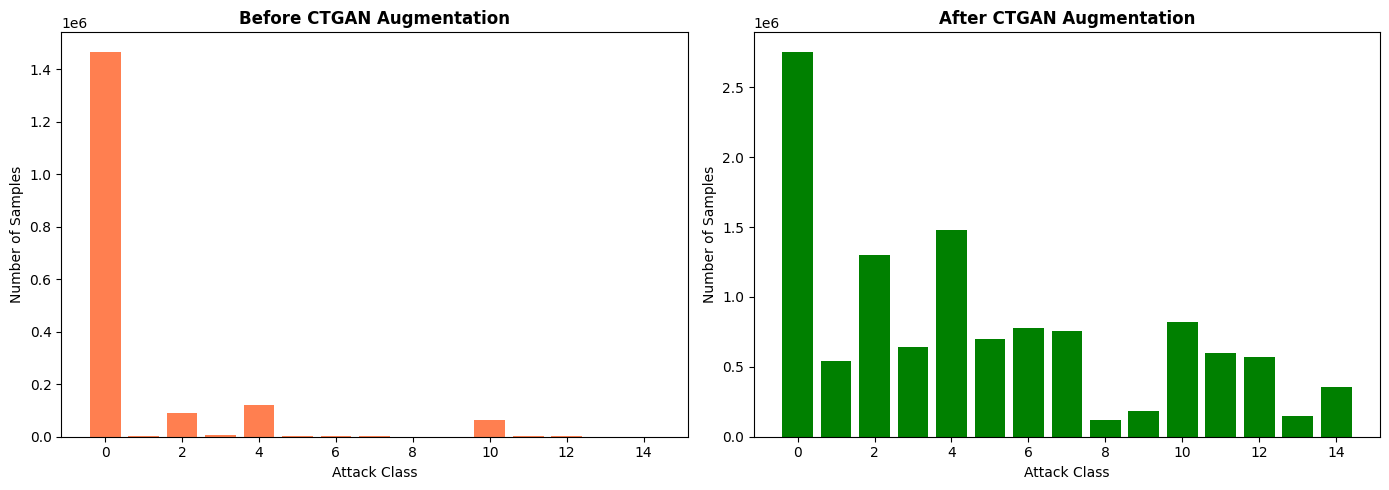


Imbalance ratio improvement:
  Before: 183442.38:1
  After: 23.45:1
  Improvement: 100.0%


In [ ]:
# ============================================
# SECTION 9: Combine Real and Synthetic Data
# ============================================

print("\n" + "="*60)
print("COMBINING REAL AND SYNTHETIC DATA")
print("="*60)

# Combine original and synthetic data
augmented_data = pd.concat([train_data, synthetic_df], ignore_index=True)

print(f"\nOriginal training data: {len(train_data):,} samples")
print(f"Synthetic data: {len(synthetic_df):,} samples")
print(f"Augmented data: {len(augmented_data):,} samples")
print(f"Increase: {(len(synthetic_df)/len(train_data)*100):.1f}%")

# Show new class distribution
print("\n" + "="*60)
print("AUGMENTED CLASS DISTRIBUTION")
print("="*60)

augmented_class_counts = augmented_data['Label_Encoded'].value_counts().sort_index()
print(augmented_class_counts)

# Visualize before/after comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before
axes[0].bar(class_counts.index, class_counts.values, color='coral')
axes[0].set_title('Before CTGAN Augmentation', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Attack Class')
axes[0].set_ylabel('Number of Samples')

# After
axes[1].bar(augmented_class_counts.index, augmented_class_counts.values, color='green')
axes[1].set_title('After CTGAN Augmentation', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Attack Class')
axes[1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

# Calculate improvement in balance
new_imbalance_ratio = augmented_class_counts.max() / augmented_class_counts.min()
print(f"\nImbalance ratio improvement:")
print(f"  Before: {imbalance_ratio:.2f}:1")
print(f"  After: {new_imbalance_ratio:.2f}:1")
print(f"  Improvement: {((imbalance_ratio - new_imbalance_ratio)/imbalance_ratio*100):.1f}%")

In [ ]:
# ============================================
# SECTION 10: Save Augmented Dataset
# ============================================

print("\n" + "="*60)
print("SAVING AUGMENTED DATASET")
print("="*60)

# Split features and labels
X_augmented = augmented_data.drop('Label_Encoded', axis=1)
y_augmented = augmented_data['Label_Encoded']

# Save to CSV
X_augmented.to_csv('X_train_augmented_cicids2017.csv', index=False)
y_augmented.to_csv('y_train_augmented_cicids2017.csv', index=False)

# Also save synthetic data separately for analysis
synthetic_df.to_csv('synthetic_data_cicids2017.csv', index=False)

# Save CTGAN model
ctgan.save('ctgan_model_cicids2017.pkl')

print("✓ Files saved successfully!")
print("\nCreated files:")
print("  - X_train_augmented_cicids2017.csv (augmented training features)")
print("  - y_train_augmented_cicids2017.csv (augmented training labels)")
print("  - synthetic_data_cicids2017.csv (synthetic samples only)")
print("  - ctgan_model_cicids2017.pkl (trained CTGAN model)")

print("\n" + "="*60)
print("CTGAN SYNTHETIC DATA GENERATION COMPLETE!")
print("="*60)

print("\nSummary:")
print(f"  • Original samples: {len(train_data):,}")
print(f"  • Synthetic samples: {len(synthetic_df):,}")
print(f"  • Total augmented samples: {len(augmented_data):,}")
print(f"  • Minority classes augmented: {len(minority_classes)}")
print(f"  • Imbalance reduced by: {((imbalance_ratio - new_imbalance_ratio)/imbalance_ratio*100):.1f}%")

print("\nNext Steps:")
print("  1. Use augmented data for transformer training")
print("  2. Develop GNN architecture")
print("  3. Build hybrid ensemble meta-learner")


SAVING AUGMENTED DATASET
✓ Files saved successfully!

Created files:
  - X_train_augmented_cicids2017.csv (augmented training features)
  - y_train_augmented_cicids2017.csv (augmented training labels)
  - synthetic_data_cicids2017.csv (synthetic samples only)
  - ctgan_model_cicids2017.pkl (trained CTGAN model)

CTGAN SYNTHETIC DATA GENERATION COMPLETE!

Summary:
  • Original samples: 1,765,653
  • Synthetic samples: 9,974,652
  • Total augmented samples: 11,740,305
  • Minority classes augmented: 14
  • Imbalance reduced by: 100.0%

Next Steps:
  1. Use augmented data for transformer training
  2. Develop GNN architecture
  3. Build hybrid ensemble meta-learner
